# 텐서플로우를 이용하여 패션 MNIST 데이터 분류하기

### plot_model()을 이용하여 시각화를 하기 위해 필요한 모듈 설치

In [1]:
#!pip install pydot

In [2]:
#!pip install graphviz 

In [3]:
# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다. 
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

C:\Users\LG\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 패션 MNIST 데이터 불러오기
- 케라스 API를 이용하여 패션 MNIST데이터 로딩 및 전처리
- 완전 연결 신경망에서는 입력 이미지를 밀집층에 넣기 전에 1차원으로 변경이 필요(reshape() 또는 Flatten사용)
- 합성곱 신경망에서는 2차원 이미지를 그대로 사용하므로 1차원으로 변경하지 않음
- 1차원으로 변경하지 않는 대신 입력 이미지는 깊이(채널) 차원이 있어야 하므로 이를 추가하는 작업이 필요(reshape()사용)
    - Conv2D 클래스로 층을 생성하려면 깊이(채널) 차원이 파라미터에 명시되어야 함
- 데이터 스케일 변경 및 훈련 데이터셋과 검증 데이터셋으로 나눔
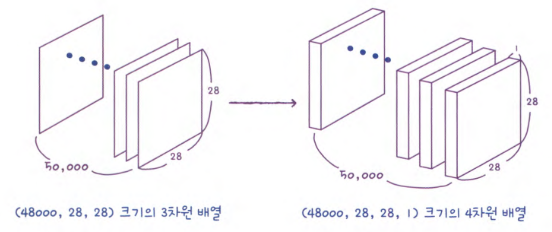

In [4]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

# 데이터 로딩
(X_train, y_train), (X_test, y_test) = \
    keras.datasets.fashion_mnist.load_data()

# 스케일 변경 및 깊이 차원 추가
X_train_scaled = X_train.reshape(-1, 28, 28, 1) / 255.0

# 훈련 데이터와 검증 데이터로 분할
X_train_scaled, X_test_val_scaled, y_train, y_test_val = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42)

In [5]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [6]:
X_train_scaled.shape, y_train.shape

((48000, 28, 28, 1), (48000,))

In [7]:
X_test_val_scaled.shape, y_test_val.shape

((12000, 28, 28, 1), (12000,))

## 합성곱 신경망 만들기
- 합성곱 층으로 이미지에서 특징을 찾을 수 밀집층에서 분류 확률 계산

#### Sequential 객체 생성

In [8]:
model = keras.Sequential()

#### 첫 번째 합성곱 층 추가
- Conv2D 생성
- 필터 개수: 32
- 커널 크기: (3,3)
- 활성화 함수: ReLU
- 패딩: same
- input_shape: 입력 데이터의 차원 지정 (28,28,1) 마지막 1이 깊이를 표현(필수)

In [9]:
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', 
                              padding='same', input_shape=(28,28,1)))

C:\Users\LG\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### 풀링 층 추가
- MaxPooling2D, AveragePooling2D 등을 사용
- 기본적인 풀링 적용(2,2)

In [10]:
model.add(keras.layers.MaxPooling2D(2))

#### 풀링 적용 후 출력 데이터
- (28,28)에 세임 패딩 적용으로 합성곱 층을 통과한 특성맵은 입력과 동일하게 (28,28)
- (2,2)풀링 적용으로 특성맵이 절반으로 줄어들고 합성곱 층에서 32개의 필터를 적용했으므로 특성맵 깊이는 32
- 결국 최대풀링을 통과한 특성맵의 크기는 (14,14,32)

#### 두 번째 합성곱+풀링 층 추가하기
- 필터 개수: 64
- 나머지는 이전과 동일하게 생성

In [11]:
model.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', 
                              padding='same'))
model.add(keras.layers.MaxPooling2D(2))

#### 두 번째 합성곱+풀링 층 적용 후
- 첫 번째 합성곱+풀링층을 통과한 특성맵은 두 번째 합성곱+풀링층 통과 후 (7,7,64)의 특성맵으로 만들어짐

#### 분류를 위한 층 추가
- Flatten층을 적용하여 (7,7,64)의 특성맵을 1차원으로 변경
- 밀집 은닉층을 추가(100개 뉴런)
- 드랍아웃 층 추가(과대적합 방지)
- 마지막에 출력층 추가(10개 뉴런)하는데 활성화 함수는 softmax적용(10개 클래스의 다중분류 이므로)

In [12]:
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(10, activation='softmax'))

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │         313,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 333,526 (1.27 MB)

 Trainable params: 333,526 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

##### 해석
- 첫 번째 합성곱을 통과하며 특성맵의 깊이가 32가 됨
- 두 번째 합성곱에서 특성맵 크기가 64로 늘어남
- 가로 세로 크기는 절반씩 줄어듦
- 최종 특성은 (7,7,64)
- 모델 파라미터 개수 확인

In [14]:
# conv2d_1 (Conv2D)의 모델 파라미터 개수(커널크기(3,3) * 32개 필터 + 32개 절편)
conv2d_1 = (3*3)*32+32
conv2d_1

320

In [15]:
# conv2d_2 (Conv2D)의 모델 파라미터 개수(이전 풀링층 출력32 * 커널크기(3,3) * 64개 필터 + 64개 절편)
conv2d_2 = (32*3*3)*64+64
conv2d_2

18496

In [16]:
# dense1 (Dense)의 모델 파라미터 개수(이전 풀링층 출력(7,7,64) * 현재 Dendse층 뉴런 수 100 * 절편 100)
dense_1 = (7*7*64)*100 + 100
dense_1

313700

In [17]:
# dense2 (Dense)의 모델 파라미터 개수(이전 Dense층 출력(100) * 현재 Dendse층 뉴런 수 10 * 절편 10)
dense_2 = 100*10+10
dense_2

1010

In [18]:
# 총 모델 파라미터 개수
conv2d_1 + conv2d_2 + dense_1 + dense_2

333526

#### plot_model() - 층의 구성을 그림으로 표현
- keras.utils 패키지에서 제공
- 사용을 위해 pydot, graphviz 모듈 설치 필요

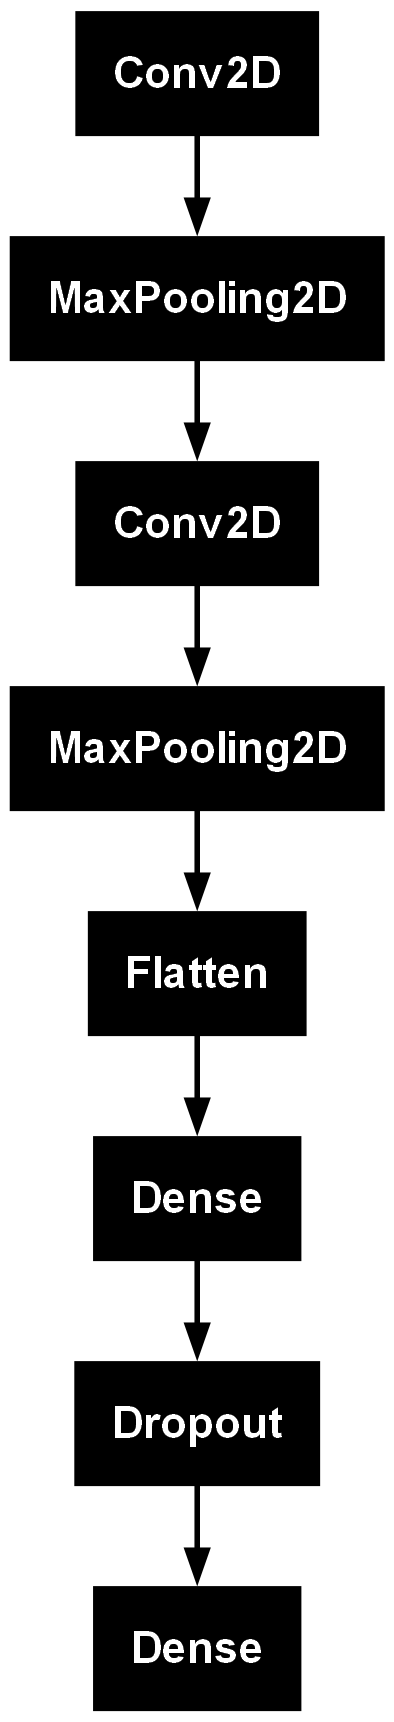

In [19]:
keras.utils.plot_model(model)

#### show_shapes 옵션
- True로 지정하면 입력과 출력의 크기를 표시
- to_file 매개변수로 파일명을 설정하면 이미지를 파일로 저장
- dpi 매개변수로 해상도 지정

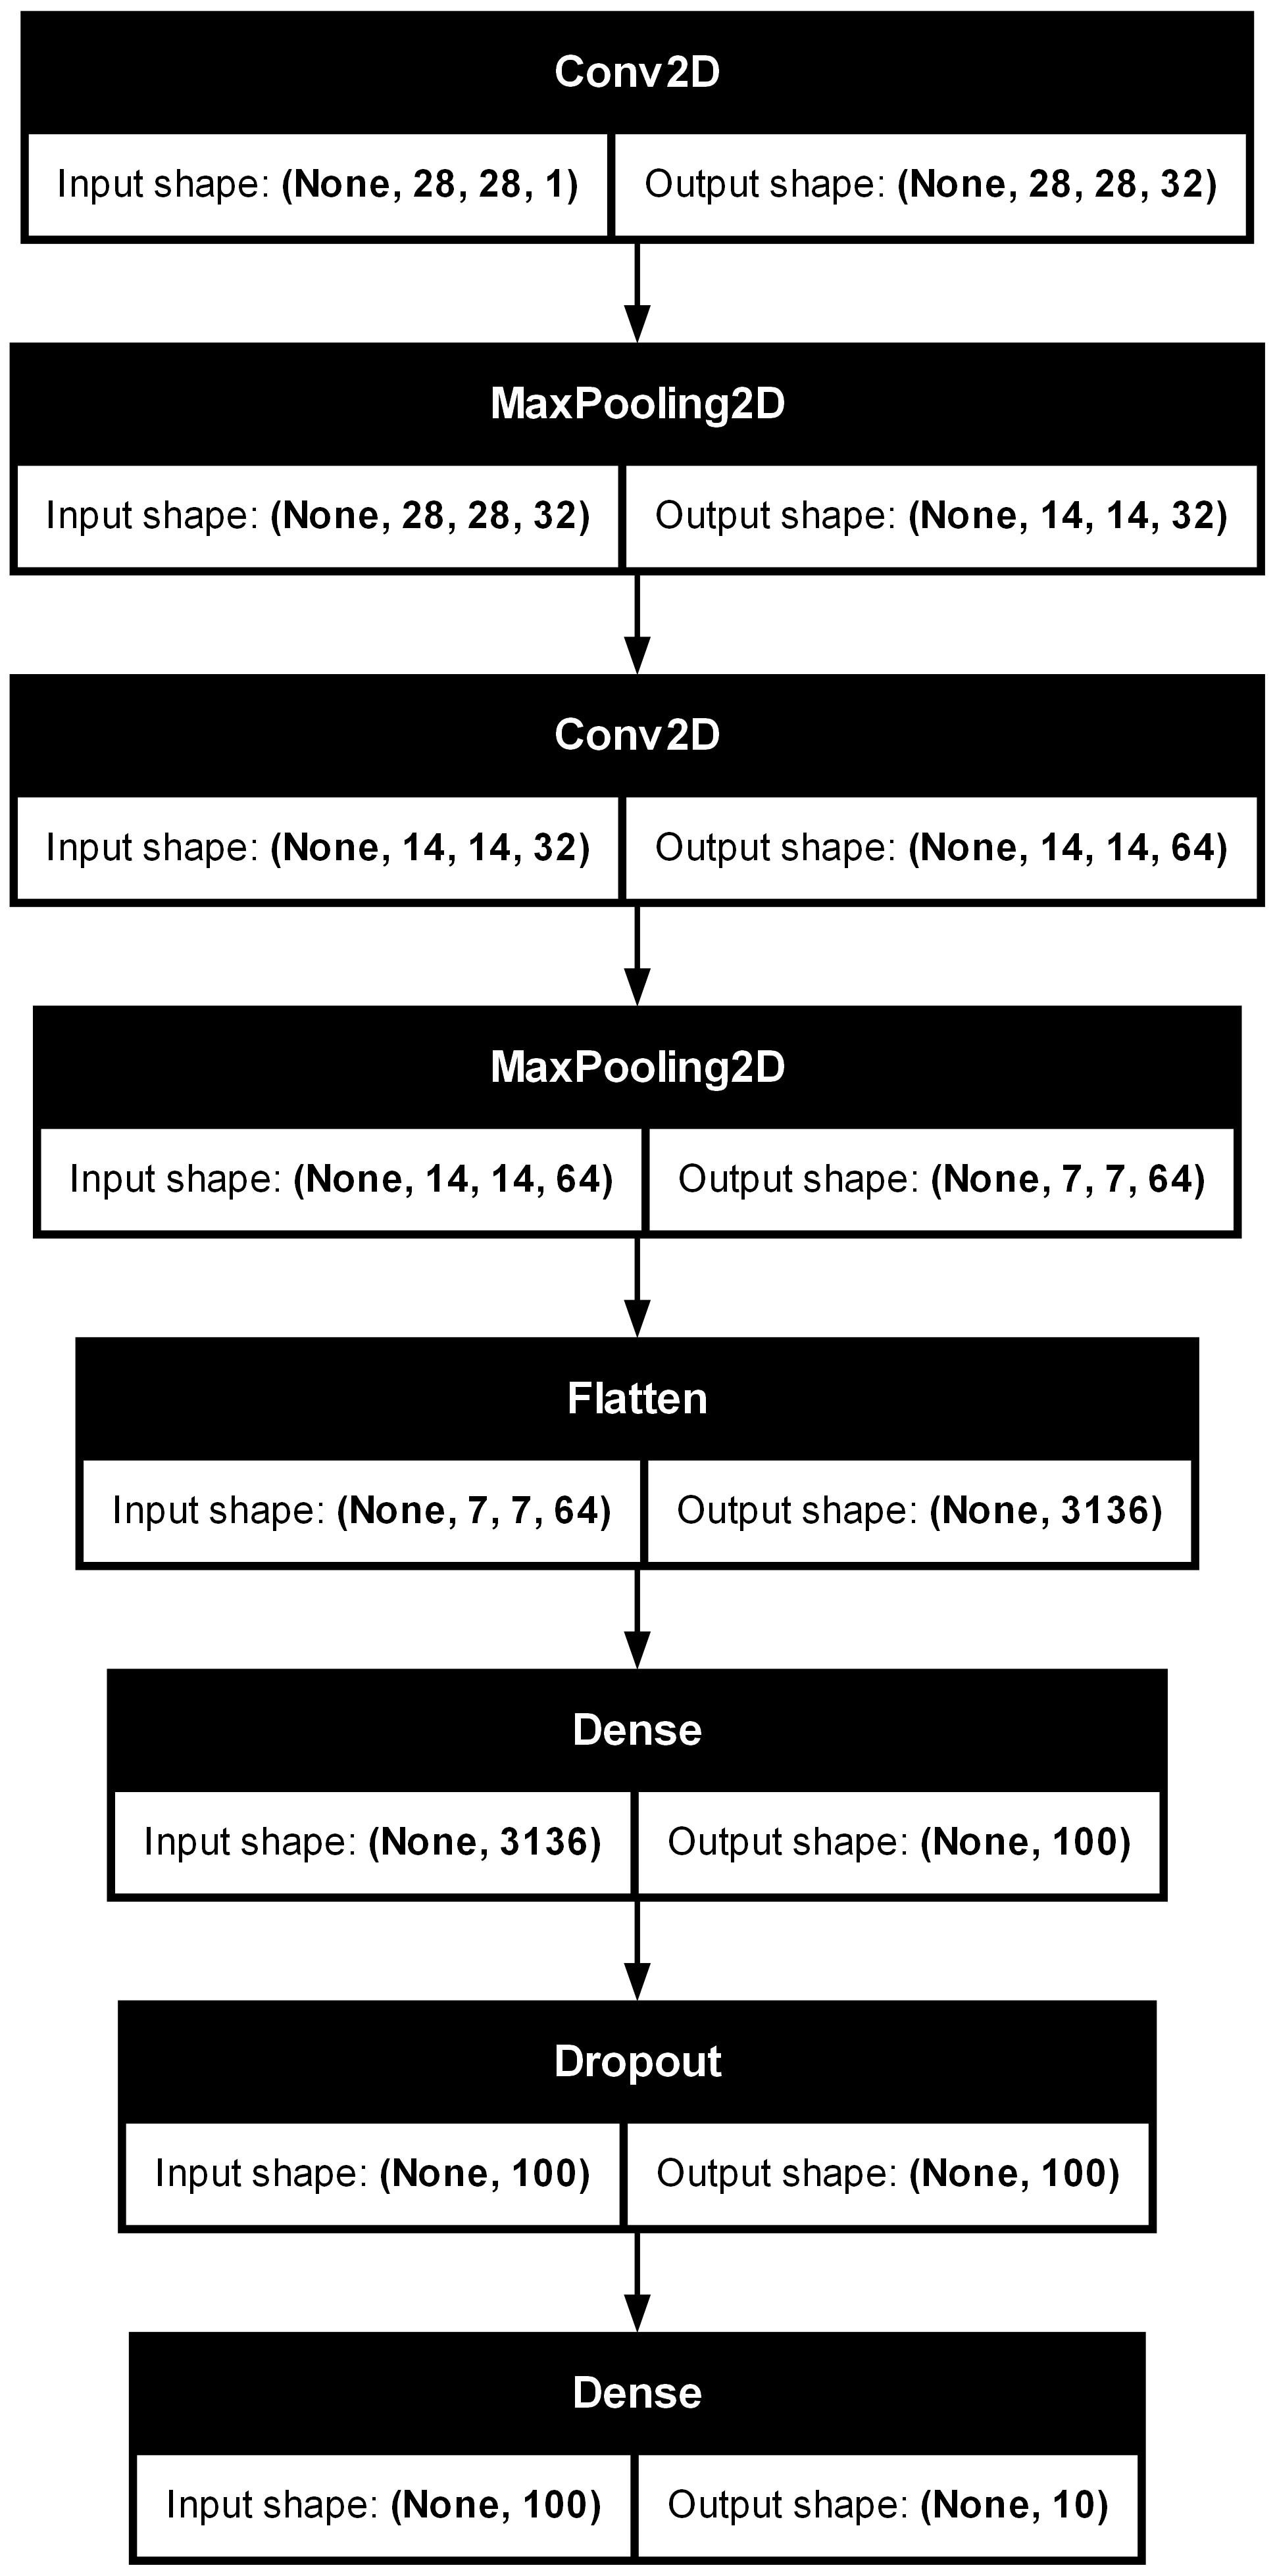

In [20]:
keras.utils.plot_model(model, show_shapes=True, to_file='cnn-architecture.png', dpi=300)

### 전체 그림으로 개념 파악
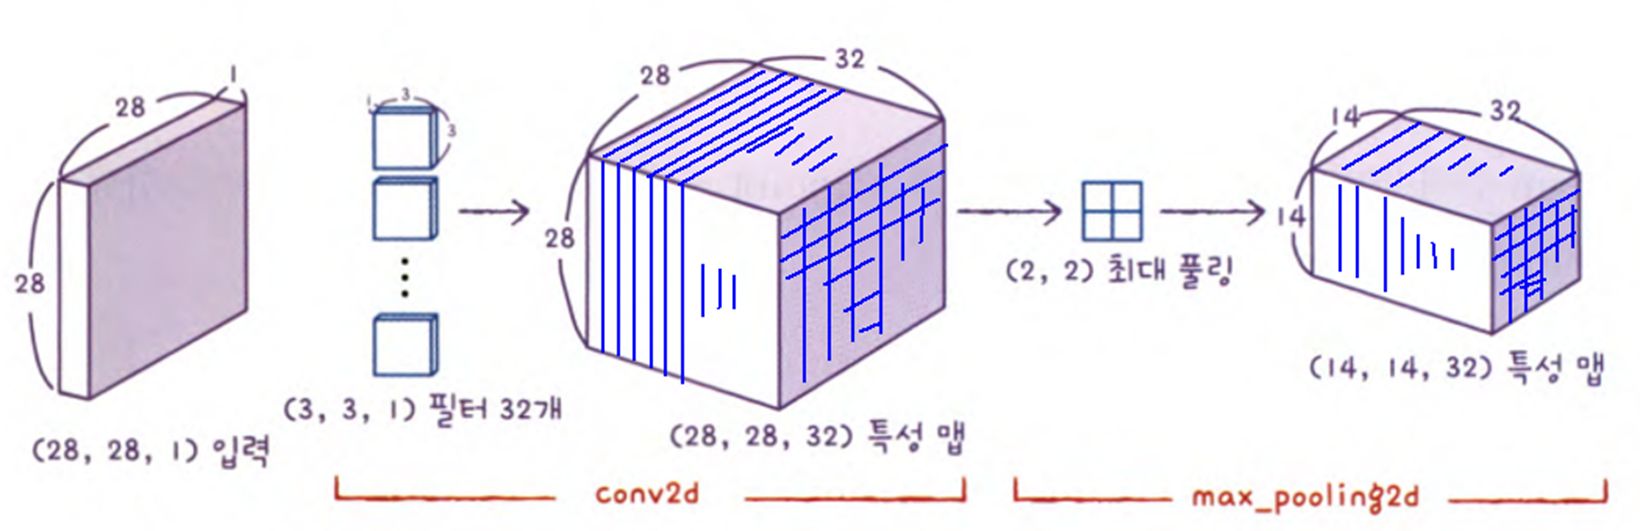
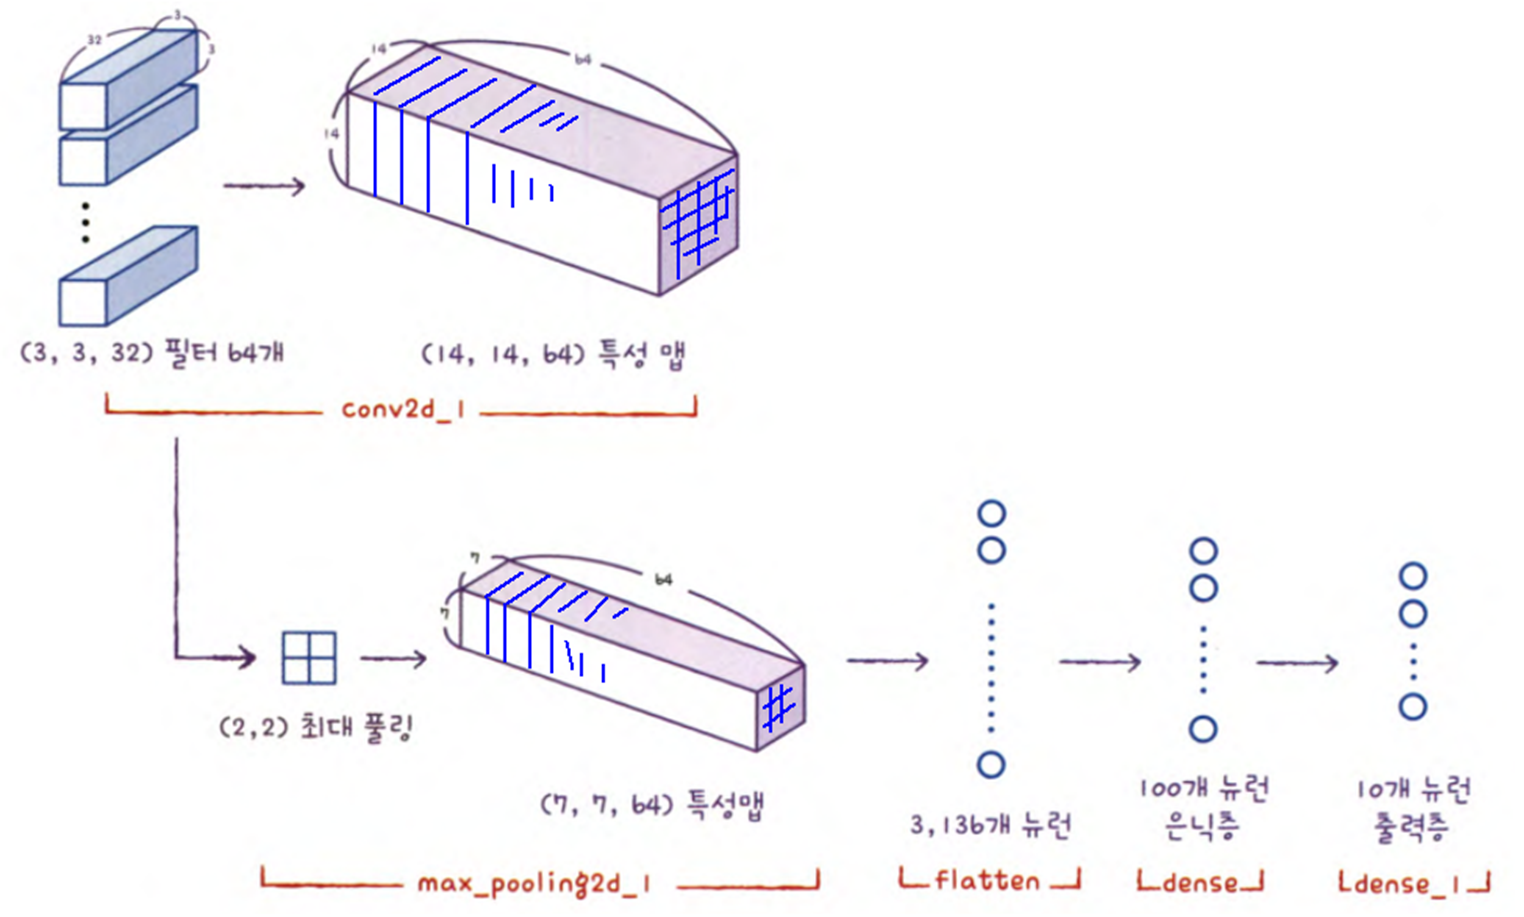

## 모델 컴파일과 훈련
- 케라스 API는 딥러닝 모델의 종류나 구성 방식과 무관하게 컴파일 및 훈련 과정에 동일한 메서드를 사용
- 예시에서 적용할 내용
    - Adam옵티마이저 사용
    - ModelCheckpoint 콜백과 EarlyStopping 콜백 함께 적용

In [21]:
from tensorflow import keras

# 모델 컴파일
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# ModelCheckpoint 콜백 정의
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    filepath=r'C:\Users\LG\Downloads\AICC_Week07\03\dl\best-cnn-model.keras', 
    save_best_only=True
)

# EarlyStopping 콜백 정의
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=2,
    restore_best_weights=True
)

# 모델 훈련
history = model.fit(
    X_train_scaled, 
    y_train, 
    epochs=20,
    validation_data=(X_test_val_scaled, y_test_val),
    callbacks=[checkpoint_cb, early_stopping_cb]
)


Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7402 - loss: 0.7264 - val_accuracy: 0.8795 - val_loss: 0.3326
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8656 - loss: 0.3687 - val_accuracy: 0.8961 - val_loss: 0.2823
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8864 - loss: 0.3095 - val_accuracy: 0.9012 - val_loss: 0.2655
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8980 - loss: 0.2779 - val_accuracy: 0.9097 - val_loss: 0.2491
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9061 - loss: 0.2532 - val_accuracy: 0.9123 - val_loss: 0.2434
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9138 - loss: 0.2321 - val_accuracy: 0.9147 - val_loss: 0.2320
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9197 - loss: 0.2148 - val_accuracy: 0.9167 - val_loss: 0.2450
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9267 - loss: 0.19

##### 결과
- 훈련 세트의 정확도가 90%이상으로 많이 높아짐
- 조기종료 콜백은 잘 동작했는지 손실그래프로 확인하기

In [22]:
import matplotlib.pyplot as plt

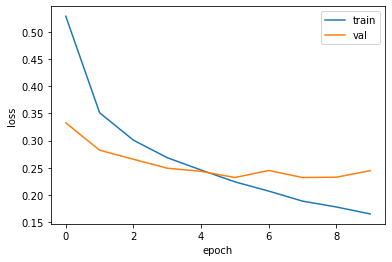

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

##### 결과
- 검증 세트에 대한 손실이 점점 감소하다가 정체되기 시작하고 훈련 세트에 대한 손실이 점점 낮아짐
- 이 그래프를 기준으로 최적의 에포크 횟수를 판단할 수 있음(5 ~ 6 에포크가 최적인 것으로 추측)
- EarlyStopping클래스에서 restore_best_weights=True를 지정했으므로 현재 model객체가 최적 모델 파라미터로 복원되어 있음
- ModelCheckpoint콜백이 저장한 best_cnn_model.h5 파일을 다시 읽어들이지 않아도 됨

In [24]:
# 테스트 세트에 대한 성능 확인
model.evaluate(X_test_val_scaled, y_test_val)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9227 - loss: 0.2305


[0.23196473717689514, 0.92166668176651]

##### 결과
- fit() 메서드의 출력 내용 중 6번째 에포크의 정확도와 같음
- EarlyStopping콜백이 model객체를 최상의 모델 파라미터로 복원했다는 것을 알 수 있음

#### predict()를 이용하여 새로운 데이터에 대한 예측 확인
- 편의상 첫 번째 샘플을 새로운 이미지로 가정
- 이미지 확인

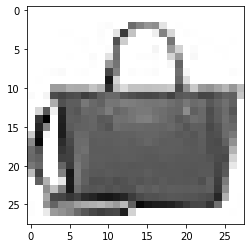

In [25]:
# 맷플롯립에서는 흑백이지미에 깊이 차원이 없음
# (28,28,1)크기를 (28,28)로 변경해야 인식됨
plt.imshow(X_test_val_scaled[0].reshape(28, 28), cmap='gray_r')
plt.show()

#### 검증용 데이터에서 1번째 이미지데이터를 신경망 모델에 전달하여 예측
- predict()에 새로운 데이터를 전달할 때 입력의 첫 번째 차원이 배치 차원일 것으로 알고 동작함(fit(), evaluate() 동일) 
- 즉, 현재 예제에서 예측에 사용될 데이터는 (1,28,28,1)을 전달해야 하는 상황
- 배열 슬라이싱을 하면 인덱싱과 다르게 선택된 원소가 하나더라도 전체 차원을 유지하여 (1, 28, 28, 1)크기를 만듦

In [26]:
X_test_val_scaled[0].shape

(28, 28, 1)

In [27]:
X_test_val_scaled[0:1].shape

(1, 28, 28, 1)

In [28]:
preds = model.predict(X_test_val_scaled[0:1])
preds

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


array([[1.3359195e-22, 5.0530567e-34, 2.8895898e-24, 6.9453932e-25,
        8.6129782e-24, 1.2998068e-21, 1.5571237e-23, 6.7034232e-23,
        1.0000000e+00, 1.2828839e-24]], dtype=float32)

##### 결과
- 첫 번째 데이터를 예측했을 때 10가지의 각 클래스에 대한 확률이 나타남
- 아홉 번째 값이 1이고 나머지는 0에 가까운것을 보아 아홉 번째 클래스로 예측

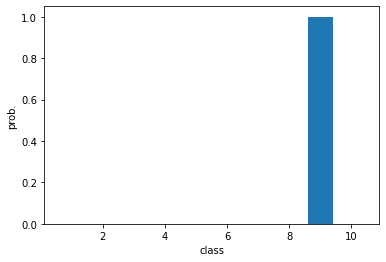

In [29]:
plt.bar(range(1, 11), preds[0])
plt.xlabel('class')
plt.ylabel('prob.')
plt.show()

#### MNIST에 설명된 클래스를 이용하여 결과를 실제 클래스와 매치

In [30]:
classes = ['티셔츠', '바지', '스웨터', '드레스', '코트',
           '샌달', '셔츠', '스니커즈', '가방', '앵클 부츠']

In [31]:
import numpy as np
classes[np.argmax(preds)] #배열에서 가장 큰 인덱스를 활용하여 클래스 문자 선택에 사용

'가방'

#### 처음에 나누어 둔 테스트 데이터 셋으로 일반화 성능을 가늠해 보기
- 픽셀값을 정규화 하고 이미지 크기 변경 후 진행

In [32]:
X_test_scaled = X_test.reshape(-1, 28, 28, 1) / 255.0

In [33]:
model.evaluate(X_test_scaled, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9132 - loss: 0.2717


[0.26105797290802, 0.9128999710083008]

##### 결과
- 테스트 세트에서 점수는 검증 세트 점수보다는 조금 낮음
- 실제 사용 시 91%의 분류 성능을 기대할 수 있을 것으로 보임

### 실습 해보기
- MNIST의 손글씨 데이터셋을 이용하여 합성곱 신경망 모델 구성해보기